In [1]:
from data_gen import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Simulation Parameters

# General
np.random.seed(42)
years = 3
T = range(365*years) 

# Seasonality 
yearly_P = 365 # yearly period
weekly_P = 7 # weekly period
beta_y_sigma = 1.5 # variance of yearly seasonality
beta_w_sigma = 0.5 # variance of weekly seasonality

# Growth
tau = (0.01)/365 # laplace prior
k = (0.03)/365 # base-rate for growth, expressed in growth per day
m = len(T)/2 # Offset parameter
C_t = 10000 # Note this is for all t, but in paper can be time-varying!
changepoint_freq = 180 # How often do changepoints occur?

# Holidays
nu = 5 # the variance of the normal distribution on holiday-effect.
kappa_1_mean = 0 # the average effect of New Years.
kappa_2_mean = 0 # the average effect of 4 of July.
kappa_3_mean = 0 # the average effect of Haloween.
kappa_4_mean = 0 # the average effect of Christmas (8 periods).

# Noise
noise_sigma = 0.00001

In [3]:
Seasonal_y, beta_y = gen_fourier(T, yearly_P, 10, sigma = beta_y_sigma)
Seasonal_w, beta_w = gen_fourier(T, weekly_P, 3, sigma = beta_w_sigma)

In [4]:
s = np.array(range(0, len(T), changepoint_freq))
a = [find_a_t(s, t = t) for t in T]
delta = gen_delta(T, 
                  changepoint_freq, 
                  tau)

In [5]:
# define a dictionary to store results
memo = {}

def find_gamma_j(j, k, delta, m):
    
    # compute gamma_l using memoization
    gamma_l = 0
    for l in range(j):
        if l in memo:
            gamma_l += memo[l]
        else:
            memo[l] = find_gamma_j(l, k, delta, m)
            gamma_l += memo[l]

    # compute delta_l using memoization
    delta_l = 0
    for l in range(j):
        if l in memo:
            delta_l += delta[l]
        else:
            delta_l += delta[l]
    
    # compute first term
    first_term = s[j] - m - gamma_l
    
    # compute second term
    second_term = (1 - (k + delta_l) / (k + delta_l + delta[j]))
    
    # compute result and store in memo
    result = first_term * second_term
    memo[j] = result
    
    return result

# initialize memo with initial values
memo[0] = find_gamma_j(0, k, delta, m=m)

# compute gamma for all j values
gamma = [memo[j] if j in memo else find_gamma_j(j, k, delta, m=m) for j in range(len(s))]


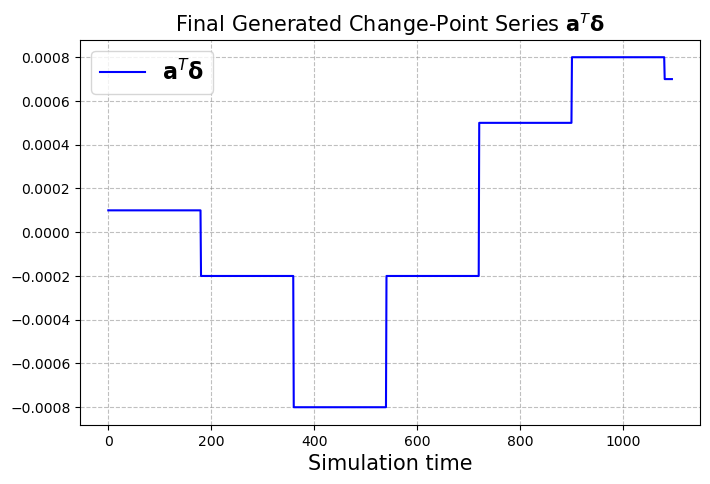

In [6]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 8, 5
# Assuming that 'delta' is a list or array of values
delta_plot = np.dot(a, delta)

# Create the plot
plt.plot(delta_plot*10, color='blue', label = r"$\mathbf{a}^T\mathbf{\delta}$")
plt.grid(True, linestyle='--', color='gray', alpha=0.5)
# Add a title
plt.title(r'Final Generated Change-Point Series $\mathbf{a}^T\mathbf{\delta}$', fontsize = 15)
plt.xlabel("Simulation time", fontsize = 15)
plt.legend(fontsize = 16)
# Show the plot
plt.show()


In [7]:
g_T = []

for t in T:
    num = C_t
    denom = 1+np.exp(-1*(k+np.dot(a[t], delta))*(t - (m+np.dot(a[t], gamma))))

    g_t = num/denom

    g_T.append(g_t)


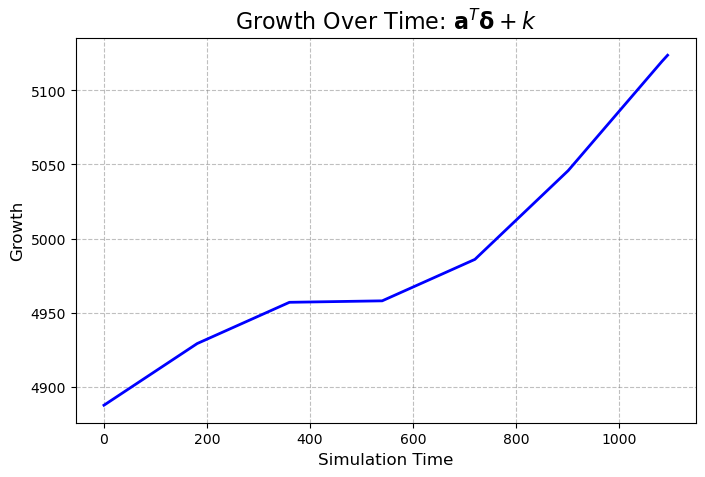

In [8]:
# create a new figure and set the size
fig, ax = plt.subplots(figsize=(8, 5))

# plot the growth rate
ax.plot(pd.DataFrame(g_T), color='blue', linewidth=2)

# set the x and y axis labels
ax.set_xlabel('Simulation Time', fontsize=12)
ax.set_ylabel('Growth', fontsize=12)

# set the title of the plot
ax.set_title(r'Growth Over Time: $\mathbf{a}^T\mathbf{\delta} + k$', fontsize=16)

# add a grid to the plot
ax.grid(True, linestyle='--', color='gray', alpha=0.5)

# remove the top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# show the plot
plt.show()

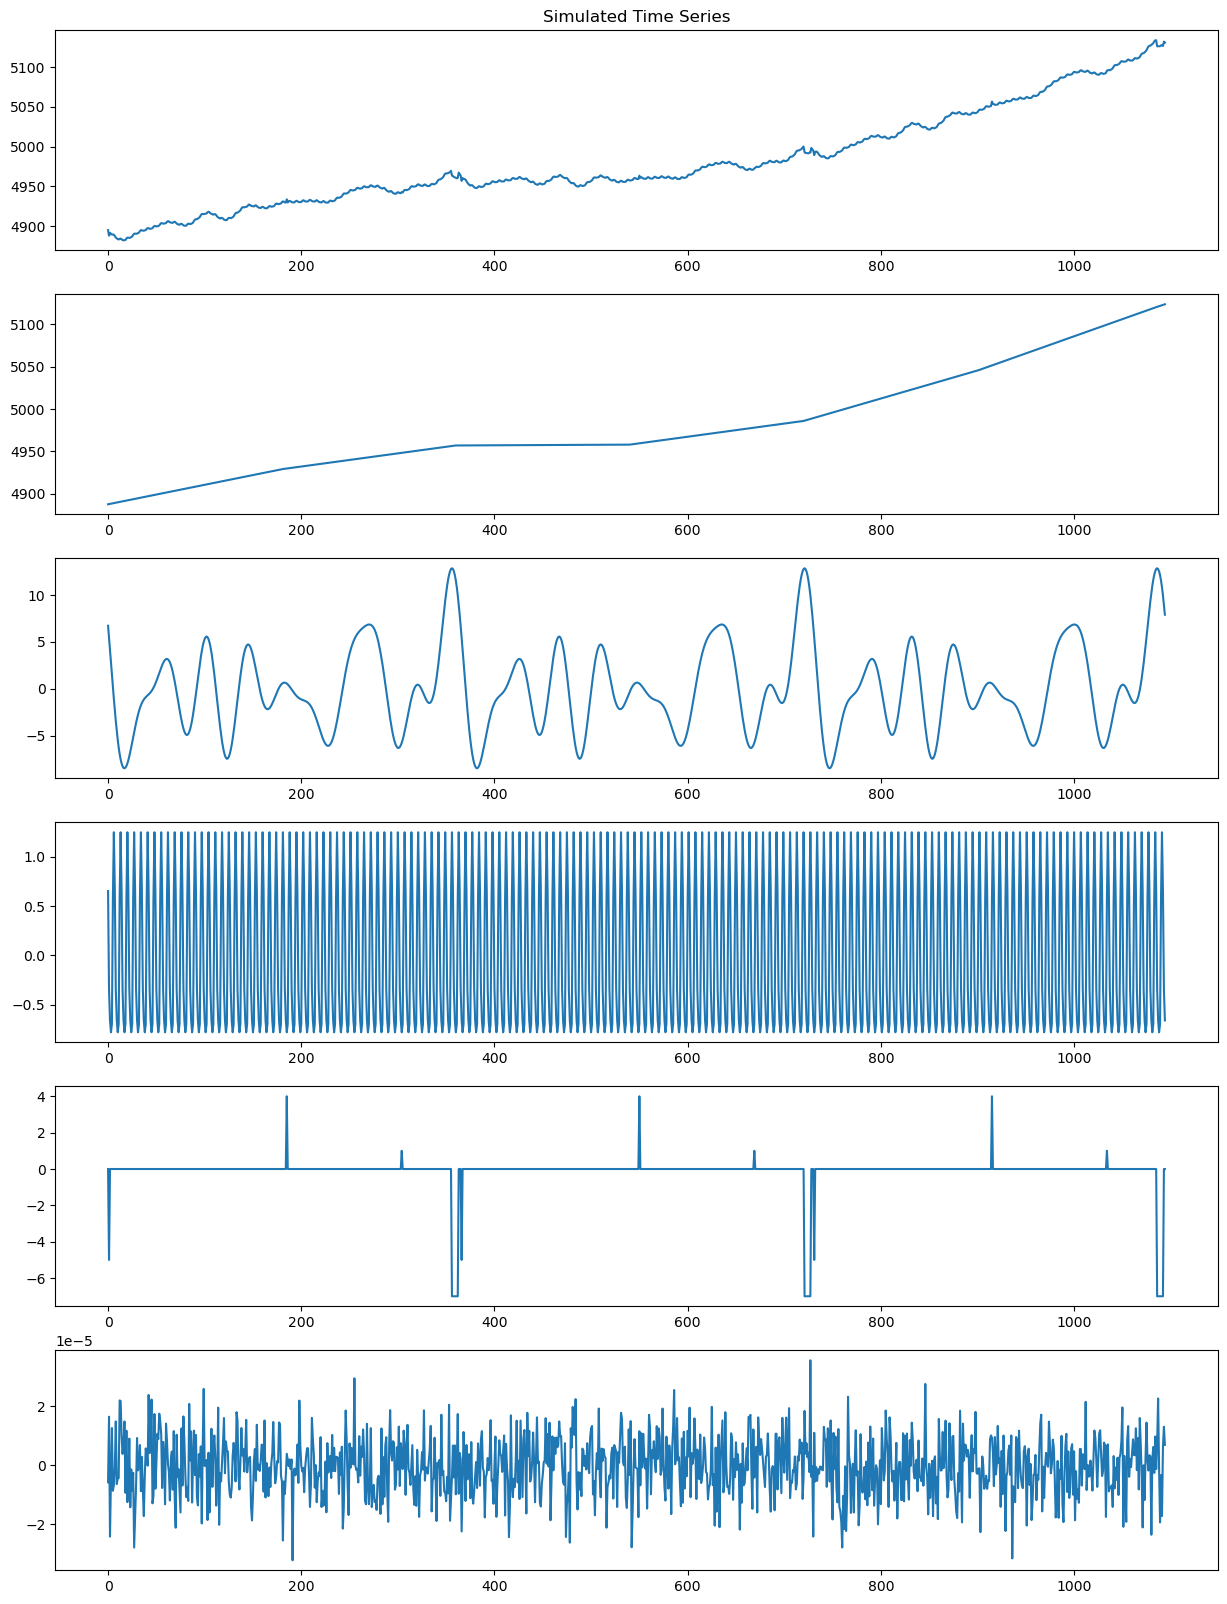

In [9]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 6)
fig.set_size_inches(15, 20)
# Set random seed for reproducibility
np.random.seed(123)

# Define time range and step
t = np.arange(0, 365*years, 1)  # 1 year, 1 day step

# Define trend, seasonality, and holiday components
g = g_T  # Linear trend
S = Seasonal_y + Seasonal_w  # Monthly and yearly seasonality
h = np.zeros_like(t)  # No holidays for now

hol_1_bump =  np.random.normal(kappa_1_mean, nu)
hol_2_bump = np.random.normal(kappa_2_mean, nu)
hol_3_bump = np.random.normal(kappa_3_mean, nu)
hol_4_bump = np.random.normal(kappa_4_mean, nu)

NYD = 1
CHRISTMAS = np.arange(356, 363)
FOURTH_OF_JULY = 185
HALLOWEEN = 304

h[NYD] = hol_1_bump
h[FOURTH_OF_JULY] = hol_2_bump
h[HALLOWEEN] = hol_3_bump
h[356:363] = hol_4_bump

for year in range(years):

    buffer = year*365 

    h[NYD + buffer] = hol_1_bump # New Year's Day
    h[FOURTH_OF_JULY + buffer] = hol_2_bump # 4 of July
    h[HALLOWEEN + buffer] = hol_3_bump # Halloween
    h[356 + buffer:363 + buffer] = hol_4_bump # Christmas

# Simulate noise
epsilon = np.random.normal(loc=0, scale=noise_sigma, size=len(t))

# Generate time series
y = g + S + h + epsilon

# Plot the time series
ax[0].plot(t, y)
ax[0].set_title('Simulated Time Series')

# Plot the time series
ax[1].plot(t, g)

ax[2].plot(t, Seasonal_y)

ax[3].plot(t, Seasonal_w)

# Plot the time series
ax[4].plot(t, h)

# Plot the time series
ax[5].plot(t, epsilon)


In [10]:
changepoint_locs = [1 if i % changepoint_freq == 0 else 0 for i in T]
delta_iter = iter(delta)

delta_series = []

for i in range(len(changepoint_locs)):

    if changepoint_locs[i] == 1:
        delta_series.append(next(delta_iter))
    else:
        delta_series.append(0)


15:11:39 - cmdstanpy - INFO - CmdStan installation /Users/ryandeclanlucus/opt/anaconda3/lib/python3.9/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
15:11:39 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
15:11:39 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:12:09 - cmdstanpy - INFO - CmdStan done processing.
15:12:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finit

15:12:09 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 62 iterations at max treedepth (12.4%)
	Chain 2 had 78 iterations at max treedepth (15.6%)
	Chain 3 had 50 iterations at max treedepth (10.0%)
	Chain 4 had 125 iterations at max treedepth (25.0%)
	Use function "diagnose()" to see further information.


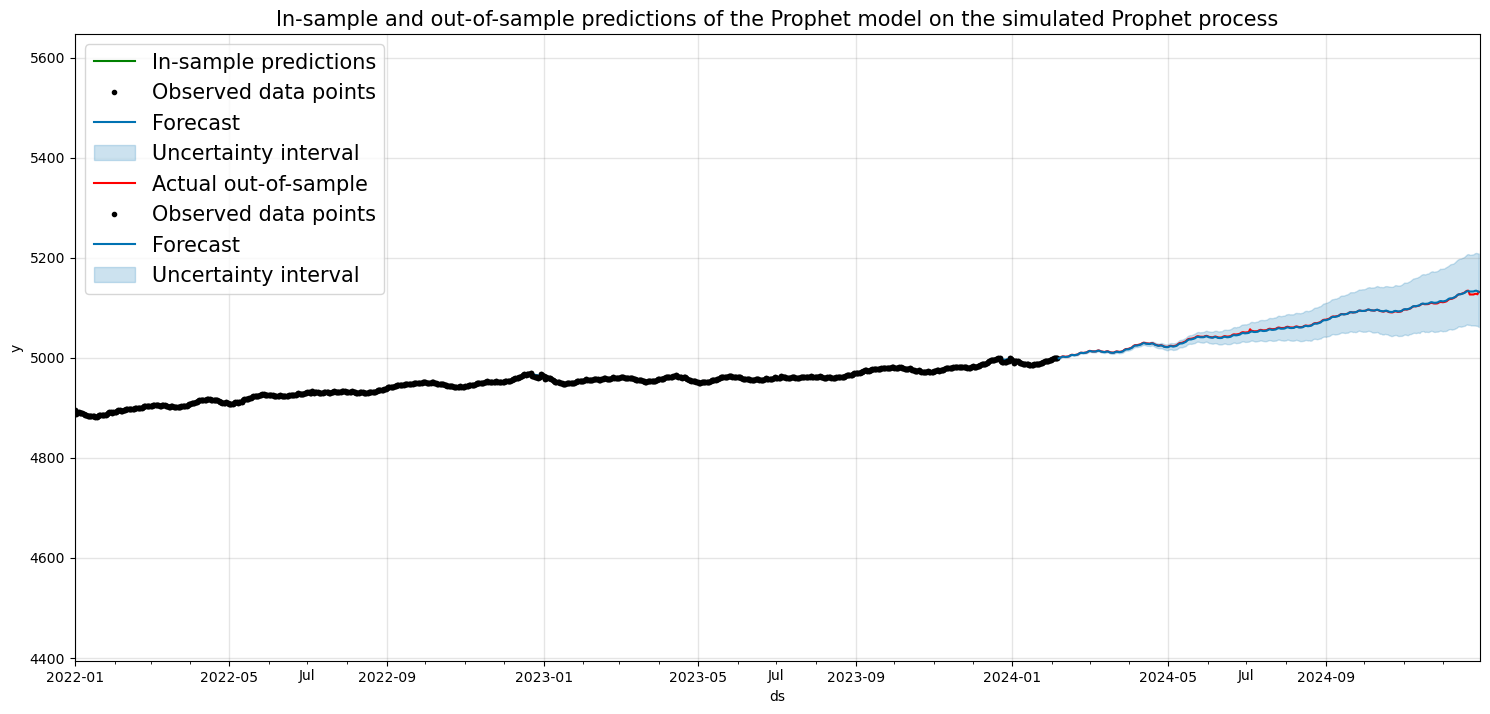

In [11]:
from prophet import Prophet

fig, ax = plt.subplots()

fig.set_size_inches(15, 7)
test_size = 0.3
train_size = 1-test_size
# Convert time series to dataframe
df = pd.DataFrame({'ds': pd.date_range(start='2022-01-01', periods=len(T), freq='D'),
                   'y': y, 'delta': delta_series})

train_df = df.iloc[:int(len(t)*train_size)]
test_periods = int(len(t)*test_size)

changepoints_known = True
n_changepoints_known = True

if n_changepoints_known:
    n_changepoints = int(len(train_df)/changepoint_freq)
else:
    n_changepoints = False

if changepoints_known:
    changepoints = train_df[train_df['delta'] != 0].ds.values
else:
    changepoints = None

# Initialize and fit Prophet model

if not n_changepoints_known:

    model = Prophet(seasonality_mode='additive',
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                holidays_prior_scale=nu,
                mcmc_samples = 1000)

else:
    model = Prophet(seasonality_mode='additive',
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False,
                holidays_prior_scale=nu,
                changepoints = changepoints, 
                n_changepoints = n_changepoints,
                mcmc_samples = 1000
                )

model.fit(train_df)

# Generate future dates for forecasting
future = model.make_future_dataframe(periods=test_periods, freq='D')

# Make predictions
forecast = model.predict(future)

df.set_index("ds", inplace=True)
train_df.set_index("ds", inplace=True)
test_df = df.iloc[-test_periods:]

# Plot the actual values and in-sample forecasts
train_df['y'].plot(ax=ax, color='green', label = 'In-sample predictions')
model.plot(forecast.iloc[:-test_periods], ax=ax, plot_cap=True)

# Plot the out-of-sample forecasts
test_df['y'].plot(ax=ax, color='red', label = 'Actual out-of-sample')
model.plot(forecast.iloc[-test_periods:], ax=ax)

ax.set_ylim(0.9*df['y'].min(), 1.1*df['y'].max())
ax.set_title("In-sample and out-of-sample predictions of the Prophet model on the simulated Prophet process", fontsize = 15)
ax.legend(fontsize = 15)
plt.show()

<AxesSubplot:ylabel='Count'>

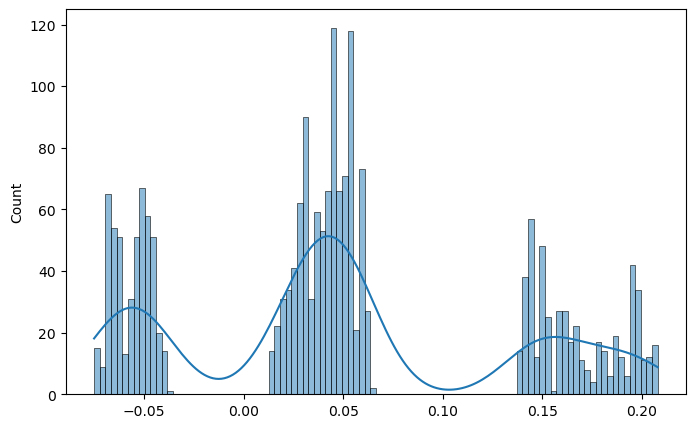

In [12]:
import seaborn as sns

sns.histplot(model.params['k'], bins = 100, kde = True)

In [13]:
in_sample_delta = delta[:int(len(delta)*train_size)]

In [14]:
in_sample_a = np.matrix(a)[:len(train_df), :len(in_sample_delta)]

In [15]:
delta_plot =  in_sample_delta.flatten()*in_sample_a.T
delta_plot = np.array(delta_plot).flatten()

In [16]:
delta_plot

array([ 1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,
        1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,
        1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,
        1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,
        1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,
        1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,
        1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,
        1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,
        1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,
        1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,
        1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,
        1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,
        1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,
        1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,  1.e-05,
        1.e-05,  1.e

In [17]:
if not changepoints_known:
    estimated_s = model.changepoints.index
else:
    estimated_s = s[:len(in_sample_delta)]

estimated_a = np.matrix([find_a_t(estimated_s, t = t) for t in range(len(train_df))])

In [18]:
vec = model.params['delta'].flatten()*estimated_a.T
vec = np.array(vec).flatten()/1000

ValueError: shapes (10000,) and (4,766) not aligned: 10000 (dim 0) != 4 (dim 0)

In [ ]:
def mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) ** 2)


In [ ]:
mean_squared_error(delta_plot*10000, vec*10000)

6.050899589449947

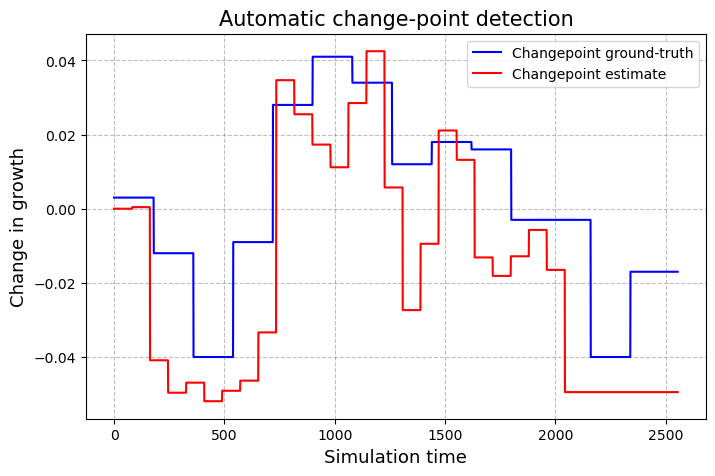

In [ ]:
# plt.plot(np.dot(a, delta) + k)
plt.plot(100*delta_plot, color = 'blue', label = "Changepoint ground-truth")
plt.plot(100*vec, color = 'red', label = "Changepoint estimate")
# plt.axhline(k, color = 'blue', label = r"Trend $k$ ground-truth", linestyle = '--')
# plt.axhline(model.params['k']/1000, color = 'red', label = r"Trend $k$ estimate", linestyle = '--')
plt.legend()
plt.grid(True, linestyle='--', color='gray', alpha=0.5)
plt.ylabel("Change in growth", fontsize = 13)
plt.xlabel("Simulation time", fontsize = 13)

if changepoints_known and n_changepoints_known:
    plt.title("Number and location of changepoints pre-specified", fontsize = 15)

elif n_changepoints_known:
    plt.title("Number of changepoints pre-specified", fontsize = 15)

else:
    plt.title("Automatic change-point detection", fontsize = 15)

In [ ]:
estimated_k = model.params['k']/1000
estimated_k = estimated_k.flatten()[0]

In [ ]:
estimated_trend = [t*estimated_k for t in range(len(train_df))]
actual_trend = [k*t for t in range(len(train_df))]

In [ ]:
Seasonal_y

array([6.72091668, 5.47063793, 4.17125556, ..., 9.9708376 , 8.99024255,
       7.90080741])

Text(0.5, 1.0, 'Weekly Seasonality')

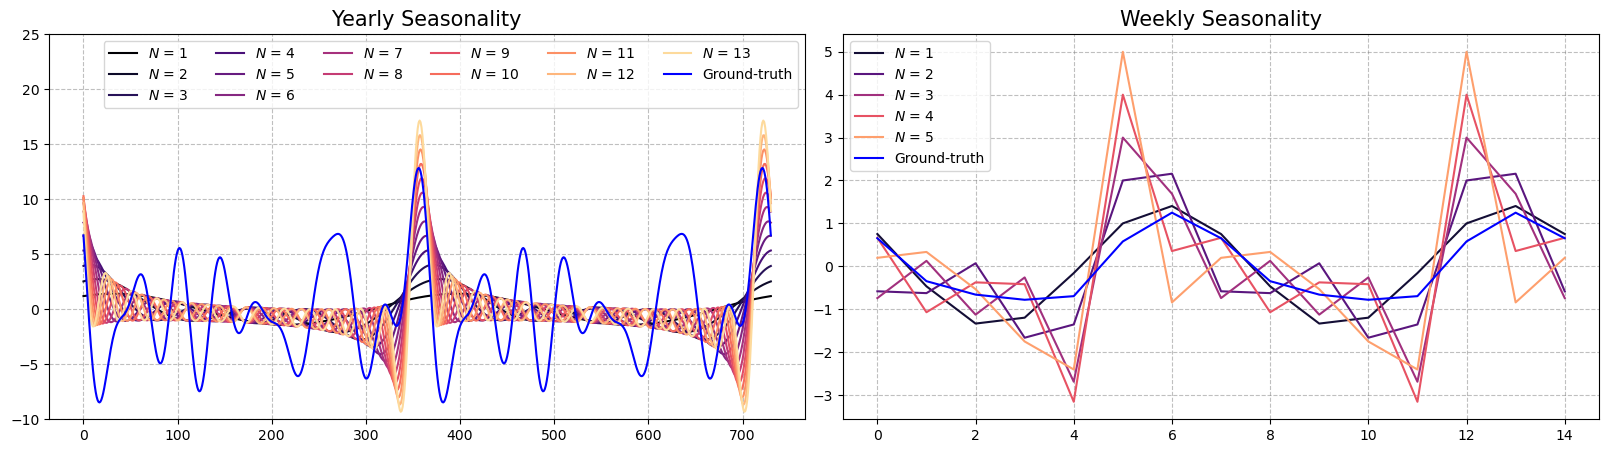

In [ ]:
import matplotlib.cm as cm
colormap = cm.magma
colors = [colormap(i) for i in np.linspace(0, 1, 14)]
colors2 = [colormap(i) for i in np.linspace(0.1, 0.8, 5)]

# Create the subplots
fig, ax = plt.subplots(ncols=2, figsize=(20, 5), gridspec_kw = {'wspace': 0.05})


MSE_y = {}

ground_truth_seasonal_Y = Seasonal_y[:len(train_df)][:365*2+1]

# Loop through the Fourier series orders and plot each one with a different color
for i in range(1, 14):
    fourier_Y = pd.DataFrame(model.fourier_series(dates=train_df.index, period=365, series_order=i)).sum(axis=1)[:365*2+1]
    fourier_Y.plot(ax=ax[0], color=colors[i-1], label=r"$N$" f" = {i}")
    MSE_y[i] = mean_squared_error(fourier_Y, ground_truth_seasonal_Y)

ax[0].plot(ground_truth_seasonal_Y, color = 'blue', label = "Ground-truth")

MSE_w = {}

ground_truth_seasonal_W = Seasonal_w[:len(train_df)][:7*2+1]

for j in range(1, 6):
    fourier_W = pd.DataFrame(model.fourier_series(dates = train_df.index, period = 7, series_order = j)).sum(axis =1)[:7*2+1]
    fourier_W.plot(ax = ax[1], color=colors2[j-1], label=r"$N$" f" = {j}")
    MSE_w[j] = mean_squared_error(fourier_W, ground_truth_seasonal_W)

ax[1].plot(ground_truth_seasonal_W, color = 'blue', label = "Ground-truth")

ax[0].legend(ncol = 6, fontsize = 10)
ax[0].set_ylim(-10, 25)
ax[1].legend()

ax[0].grid(True, linestyle='--', color='gray', alpha=0.5)
ax[1].grid(True, linestyle='--', color='gray', alpha=0.5)

ax[0].set_title("Yearly Seasonality", fontsize = 15)
ax[1].set_title("Weekly Seasonality", fontsize = 15)


In [ ]:
MSE = pd.DataFrame(MSE_y, index = [0]).T

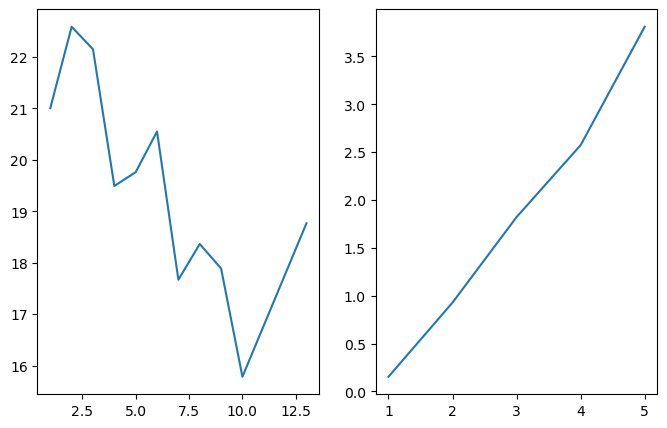

In [ ]:
fig, ax = plt.subplots(ncols = 2)

MSE_y = pd.DataFrame(MSE_y, index = [0]).T
MSE_w = pd.DataFrame(MSE_w, index = [0]).T

ax[0].plot(MSE_y)
ax[1].plot(MSE_w)

y_min = np.min(MSE.values)
x_min = MSE.idxmin()

# ax[0].annotate('minimum', xy=(x_min, y_min), xytext=(x_min+1, y_min+0.5),
            # arrowprops=dict(facecolor='black', shrink=0.05))

In [ ]:
train_df['floor']= np.min(train_df['y'])

/var/folders/q6/czkds0m930qfg8g6_k7km9cm0000gp/T/ipykernel_84674/2255551046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['floor']= np.min(train_df['y'])


In [ ]:
train_df['t'] = np.arange(len(train_df))

/var/folders/q6/czkds0m930qfg8g6_k7km9cm0000gp/T/ipykernel_84674/230798686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['t'] = np.arange(len(train_df))


In [ ]:
estimated_trend = model.sample_predictive_trend(df = train_df, iteration= 0)

In [ ]:
actual_beta = list(beta_y.flatten()) + list(beta_w.flatten())

In [ ]:
actual_beta = np.array(actual_beta)

In [ ]:
estimated_beta = model.params['beta'].flatten()

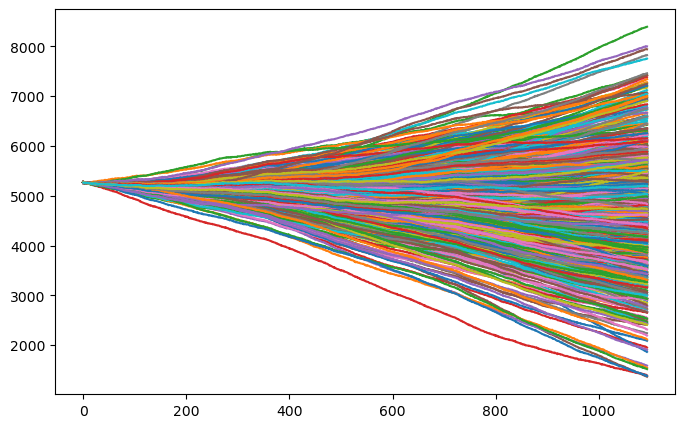

In [ ]:
plt.plot(model.predictive_samples(test_df.reset_index())['yhat'])

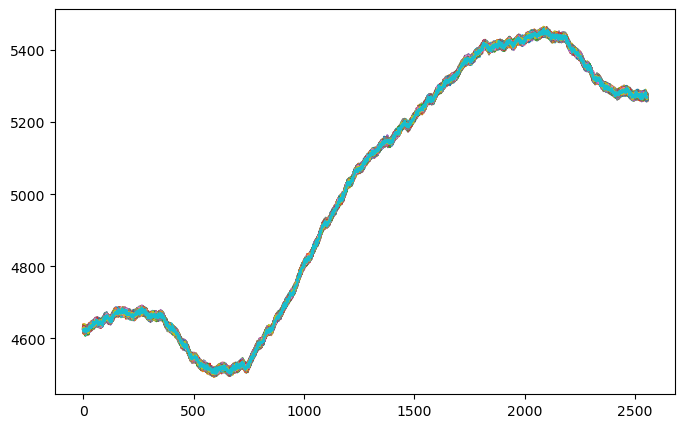

In [ ]:
plt.plot(model.predictive_samples(train_df.reset_index())['yhat'])